In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms


In [ ]:
Download images of beagles

In [2]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for consistency
    transforms.ToTensor()
])

# Load the Oxford-IIIT Pets dataset with category labels
dataset = OxfordIIITPet(root='./data', split='trainval', target_types='category', transform=transform, download=True)

# Read the breed metadata from annotations/list.txt
breed_to_index = {}
image_to_breed = []

# Path to the metadata file
annotations_path = os.path.join('./data/oxford-iiit-pet', 'annotations', 'list.txt')

with open(annotations_path, 'r') as f:
    lines = f.readlines()[6:]  # Skip header lines
    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        breed = filename.split('_')[0]
        if breed not in breed_to_index:
            breed_to_index[breed] = len(breed_to_index)
        image_to_breed.append((filename, breed))

# Find the index for "Beagle" breed
beagle_breed = "beagle"
beagle_images = [i for i, (filename, breed) in enumerate(image_to_breed) if breed == beagle_breed]

# Create a subset of the dataset with only Beagle images
beagle_dataset = Subset(dataset, beagle_images)



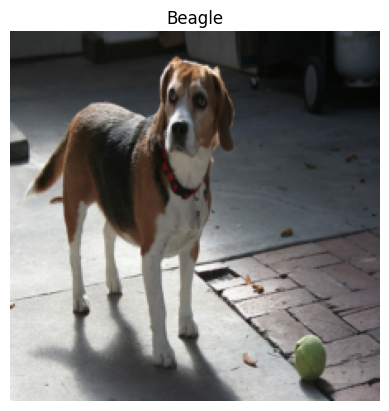

In [3]:
# Load and display one Beagle image
image, label = beagle_dataset[86]  # Get the first Beagle image

# Display the image
plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.axis("off")
plt.title("Beagle")
plt.show()


Split into patches

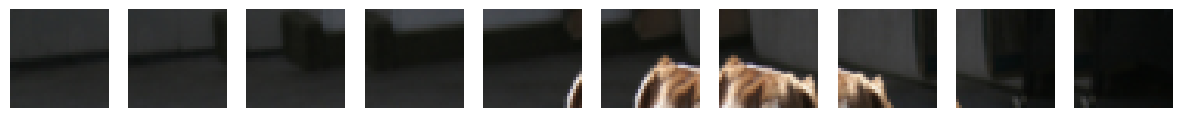

In [4]:
def extract_overlapping_patches(image_tensor, patch_size=32, stride=16, max_patches=100):
    """Extract overlapping patches from an image tensor, limited to a maximum number."""
    patches = []
    _, height, width = image_tensor.shape
    image_pil = transforms.ToPILImage()(image_tensor)  # Convert tensor to PIL Image for cropping
    
    # Loop to extract patches
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image_pil.crop((x, y, x + patch_size, y + patch_size))
            patches.append(patch)
            
            # Stop if we reach the maximum number of patches
            if len(patches) >= max_patches:
                return patches
    return patches

# Extract up to 100 overlapping patches from the selected Beagle image
patch_size = 32
stride = 16
max_patches = 100
patches = extract_overlapping_patches(image, patch_size=patch_size, stride=stride, max_patches=max_patches)

# Display the patches to verify extraction
fig, axes = plt.subplots(1, min(len(patches), 10), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(patches[i])
    ax.axis("off")
plt.show()


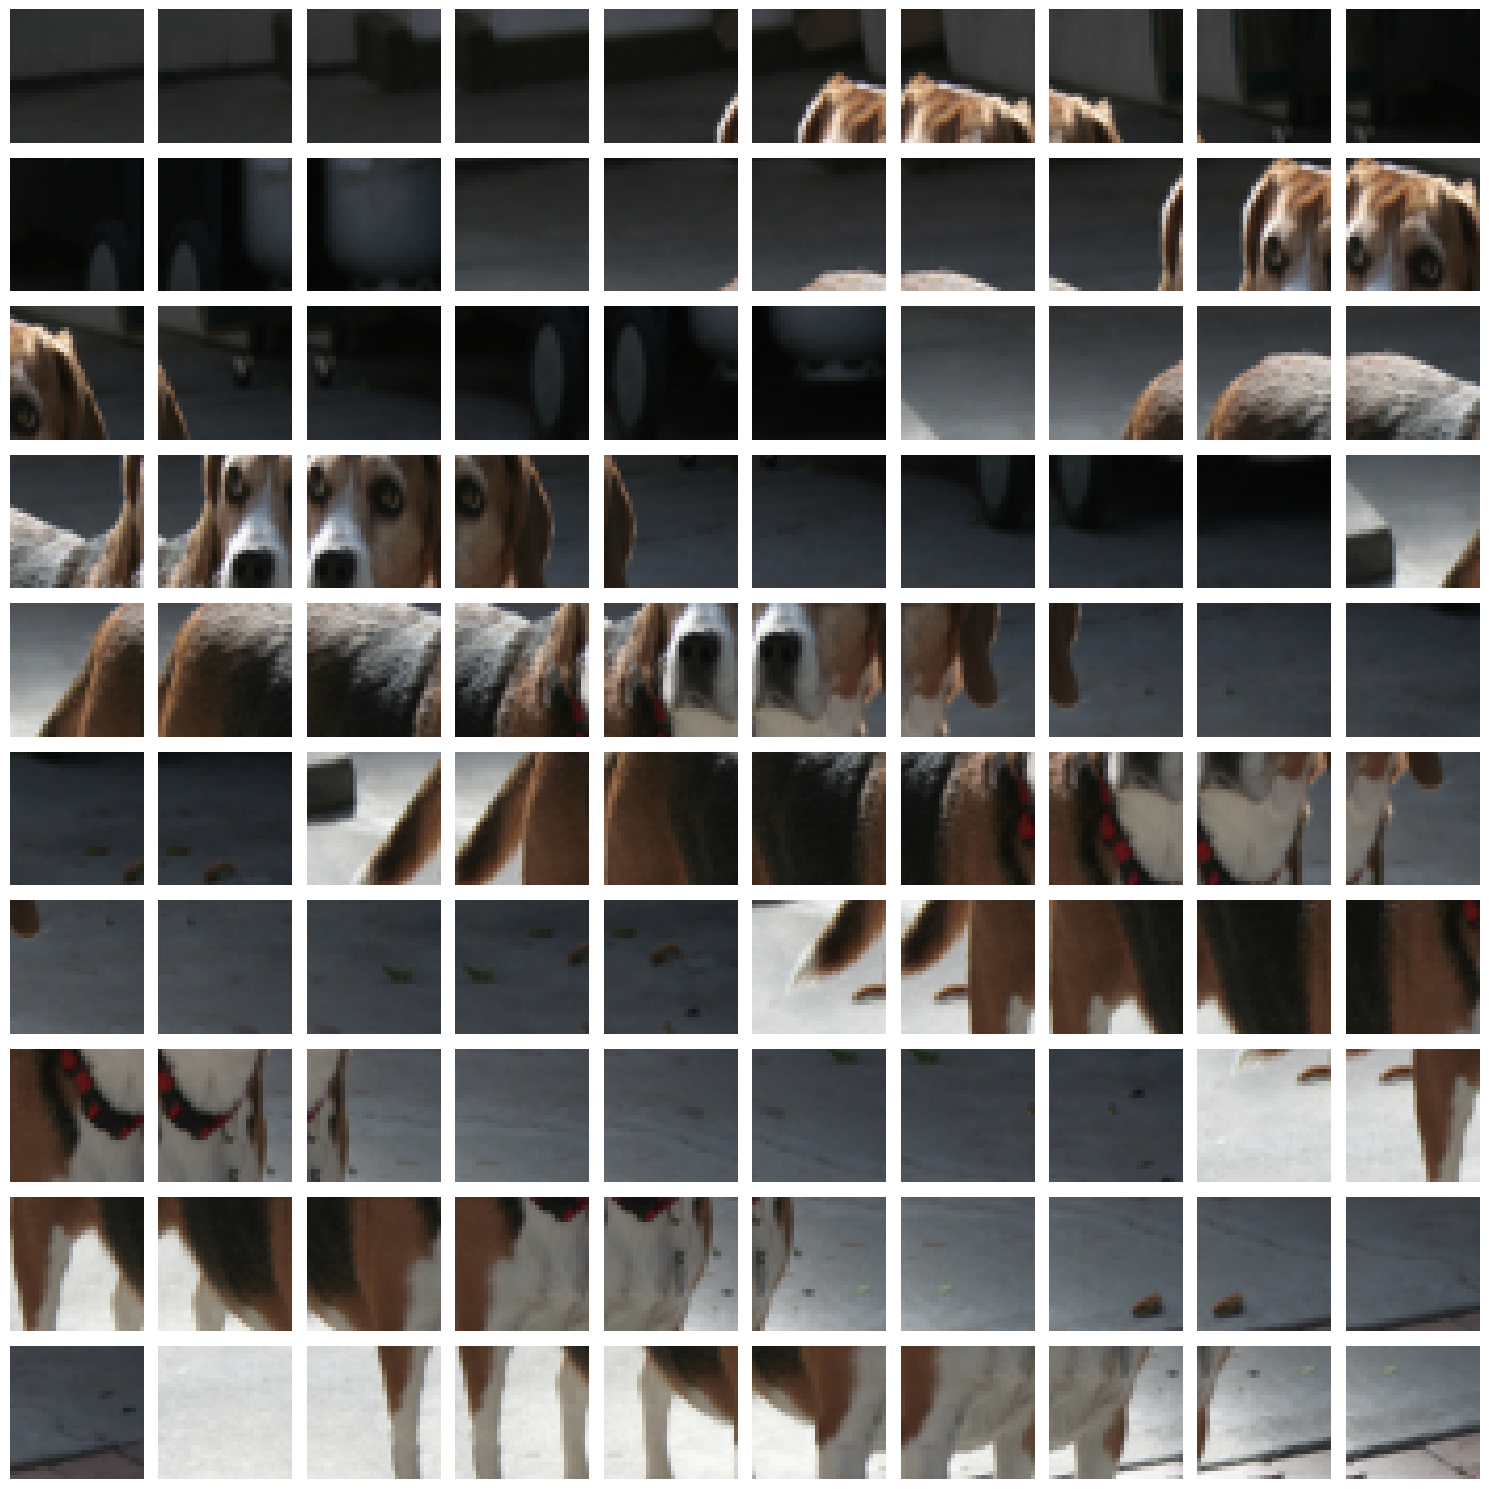

In [5]:
import math

# Calculate grid size for displaying all patches
num_patches = len(patches)
cols = 10  # Set the number of columns for the grid
rows = math.ceil(num_patches / cols)  # Calculate the necessary number of rows

# Display all patches in a grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten axes to simplify indexing

for i in range(rows * cols):
    if i < num_patches:
        axes[i].imshow(patches[i])
        axes[i].axis("off")
    else:
        axes[i].axis("off")  # Turn off axes for any extra subplot

plt.tight_layout()
plt.show()


Color augment patches

In [6]:
# Define a stronger color jitter transformation
color_jitter = transforms.ColorJitter(
    brightness=0.8, contrast=0.8, saturation=0.8, hue=0.4
)

# Apply stronger color augmentation to each patch and keep track of the original index
augmented_patches_with_indices = [(color_jitter(patch), idx) for idx, patch in enumerate(patches)]

# Check the number of augmented patches
print("Number of augmented patches with indices:", len(augmented_patches_with_indices))  # Should print 100
print("Sample augmented patch and original index:", augmented_patches_with_indices[0])


Number of augmented patches with indices: 100
Sample augmented patch and original index: (<PIL.Image.Image image mode=RGB size=32x32 at 0x113568610>, 0)


In [14]:
import torch

# Set a random seed for reproducibility
torch.manual_seed(42)

# Define a dictionary to hold both original and augmented patches
patch_dict = {}

# Populate the dictionary with original and augmented patches
for idx, patch in enumerate(patches):
    # Apply color jitter with the same random seed for consistency
    torch.manual_seed(42 + idx)  # Optional: vary seed per patch for slight randomness across patches
    augmented_patch = color_jitter(patch)  # Apply color augmentation
    patch_dict[idx] = {"original": patch, "augmented": augmented_patch}

# Check the structure and content of the dictionary for one entry
print("Sample entry in patch_dict:", patch_dict[0])  # Example with index 0


Sample entry in patch_dict: {'original': <PIL.Image.Image image mode=RGB size=32x32 at 0x104DBBD90>, 'augmented': <PIL.Image.Image image mode=RGB size=32x32 at 0x114A36880>}


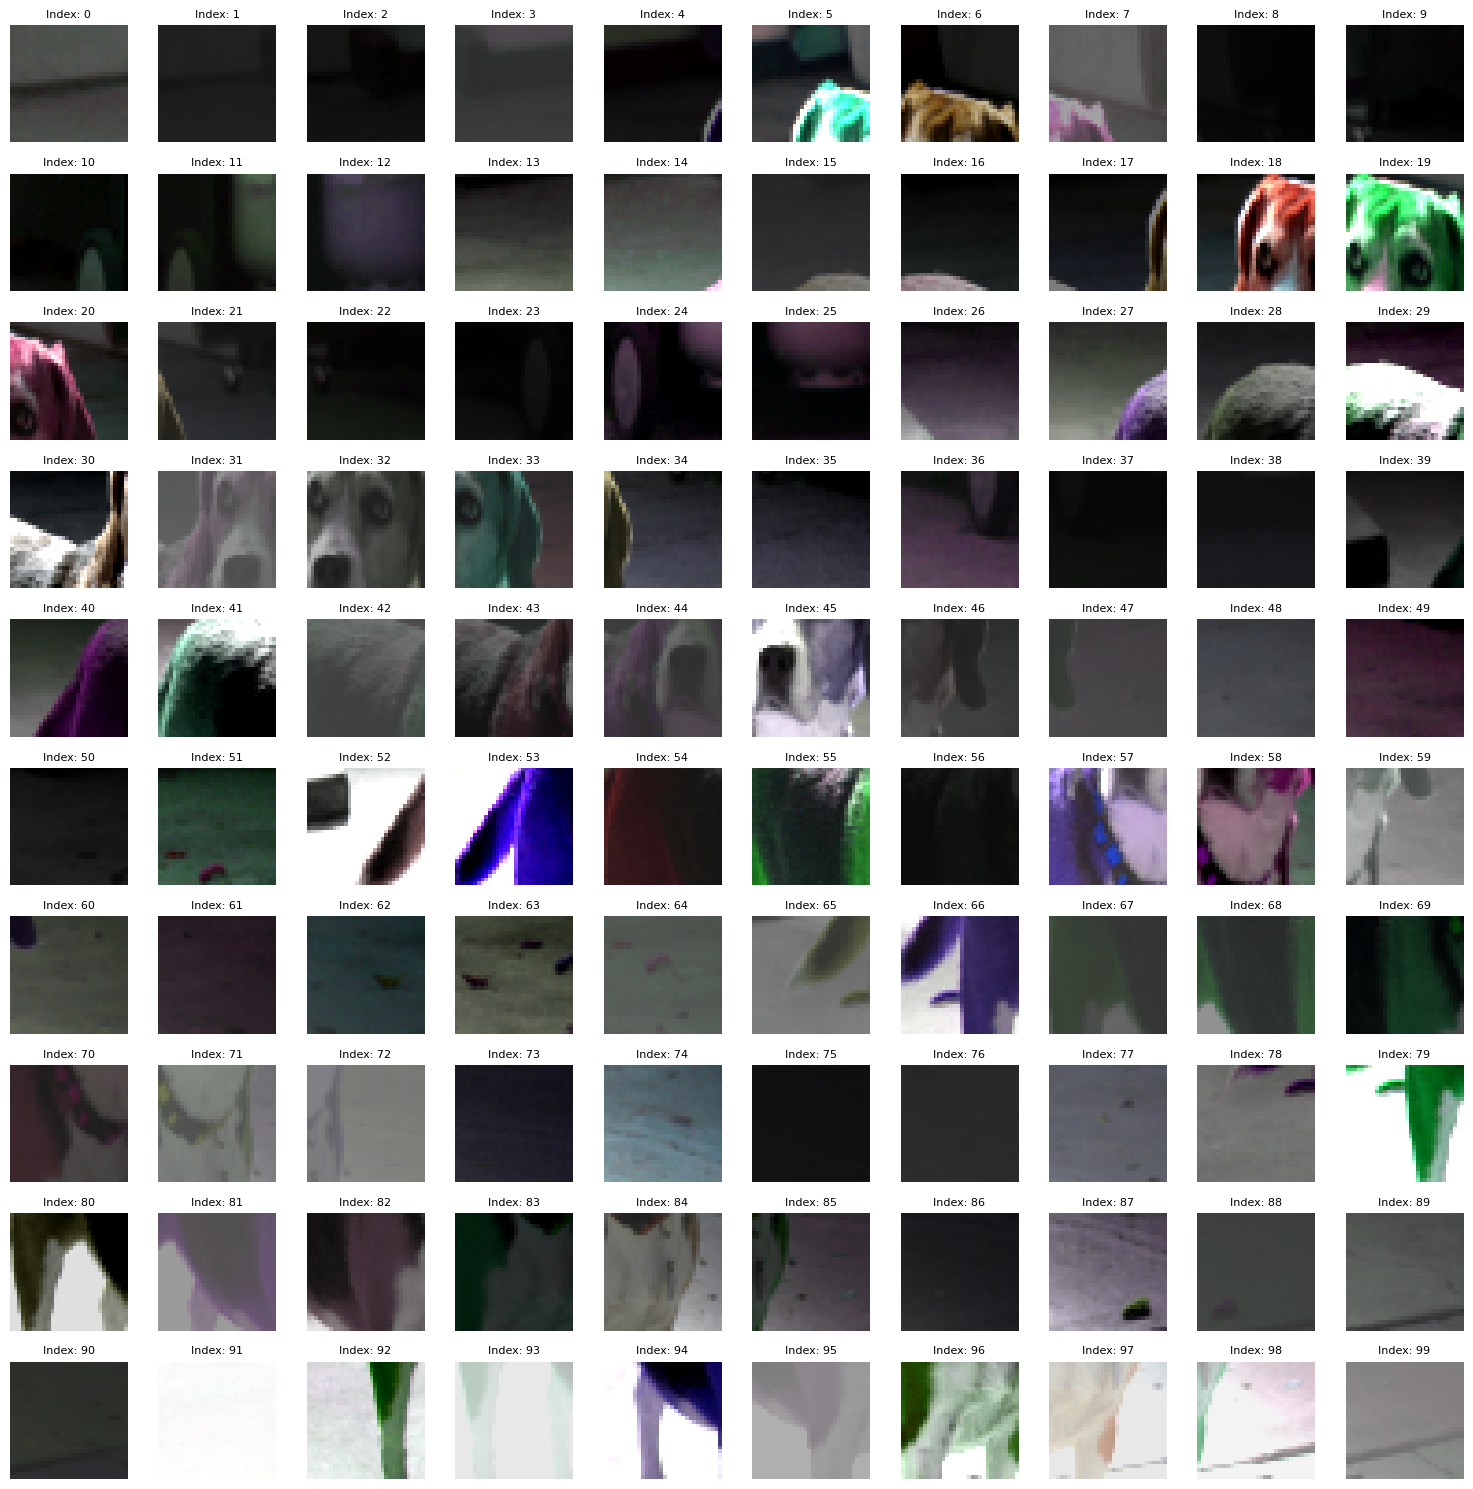

In [15]:
import math
import matplotlib.pyplot as plt

# Calculate grid size for displaying all patches
num_patches = len(patch_dict)
cols = 10  # Set the number of columns for the grid
rows = math.ceil(num_patches / cols)  # Calculate the necessary number of rows

# Display all augmented patches in a grid with their index as the title
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten axes to simplify indexing

for i, idx in enumerate(patch_dict.keys()):
    if i < num_patches:
        augmented_patch = patch_dict[idx]["augmented"]
        axes[i].imshow(augmented_patch)
        axes[i].set_title(f"Index: {idx}", fontsize=8)  # Display the index as the title
        axes[i].axis("off")
    else:
        axes[i].axis("off")  # Turn off axes for any extra subplot

plt.tight_layout()
plt.show()


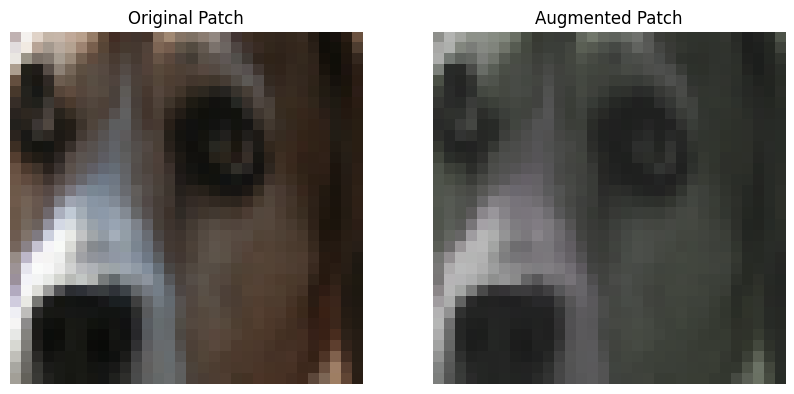

In [16]:
import matplotlib.pyplot as plt

# Select a specific index to view
index_to_view = 32  # Adjust to view different patches

# Retrieve the original and augmented patch from the dictionary
original_patch = patch_dict[index_to_view]["original"]
augmented_patch = patch_dict[index_to_view]["augmented"]

# Display the original and augmented patches side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_patch)
axes[0].set_title("Original Patch")
axes[0].axis("off")

axes[1].imshow(augmented_patch)
axes[1].set_title("Augmented Patch")
axes[1].axis("off")

plt.show()


In [17]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models

# Load a pretrained ResNet model and remove the final classification layer
model = models.resnet18(weights="IMAGENET1K_V1")
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final layer
model.eval()  # Set the model to evaluation mode


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [18]:

# Define the resize and normalization transformation to match ResNet input
resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [19]:

# Embed each augmented patch and store the embedding in the dictionary
with torch.no_grad():  # Disable gradient computation for faster processing
    for idx in patch_dict.keys():
        # Retrieve the augmented patch and apply the transformation
        augmented_patch = patch_dict[idx]["augmented"]
        patch_tensor = resize_transform(augmented_patch).unsqueeze(0)  # Add batch dimension

        # Pass through the model to get the embedding
        embedding = model(patch_tensor).squeeze().numpy()  # Squeeze to remove unnecessary dimensions

        # Store the embedding in the dictionary
        patch_dict[idx]["embedding"] = embedding

# Check one entry to verify that the embedding has been added
print("Sample entry in patch_dict with embedding:", patch_dict[0])  # Check the first entry


Sample entry in patch_dict with embedding: {'original': <PIL.Image.Image image mode=RGB size=32x32 at 0x104DBBD90>, 'augmented': <PIL.Image.Image image mode=RGB size=32x32 at 0x114A36880>, 'embedding': array([6.88539818e-02, 2.10563198e-01, 2.69057810e-01, 9.69257414e-01,
       2.06016332e-01, 4.04019877e-02, 6.31459132e-02, 9.51532662e-01,
       1.38291150e-01, 0.00000000e+00, 7.88968429e-02, 0.00000000e+00,
       0.00000000e+00, 6.33123964e-02, 0.00000000e+00, 3.16070288e-01,
       0.00000000e+00, 1.12870204e+00, 5.54111153e-02, 5.26299998e-02,
       2.01736256e-01, 8.07129219e-02, 5.37011802e-01, 2.17358842e-01,
       3.07845205e-01, 2.71487702e-02, 1.80639047e-02, 1.70832306e-01,
       1.07210480e-01, 5.37197329e-02, 4.30402756e-01, 4.20404822e-01,
       2.16171443e-02, 3.51561978e-02, 6.88644275e-02, 8.22632536e-02,
       1.42889351e-01, 2.60541346e-02, 6.98909938e-01, 1.24879740e-01,
       2.75004888e-03, 3.74925509e-02, 2.54760444e-01, 1.57265425e-01,
       1.65174693

In [20]:
patch_dict[1]["embedding"].shape

(512,)

In [ ]:
Reduce dimensionality

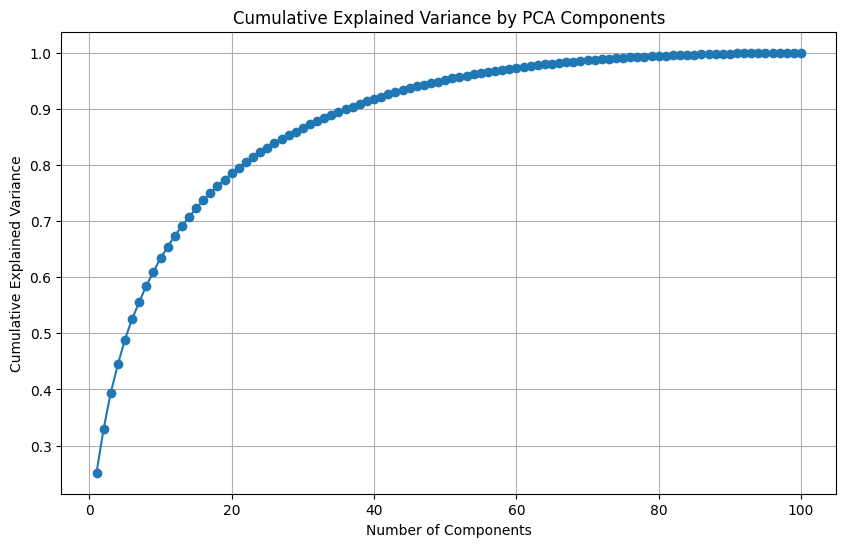

Number of dimensions to reach ~90% variance: 37


In [25]:
# Set n_components to the maximum possible value based on sample size
pca = PCA(n_components=100)  # Limited to 100 due to the number of samples
pca.fit(all_embeddings)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid()
plt.show()

# Find the number of dimensions that gets to ~90% variance
optimal_dim = np.argmax(cumulative_explained_variance >= 0.90) + 1
print(f"Number of dimensions to reach ~90% variance: {optimal_dim}")


In [26]:
# Apply PCA with the optimal number of dimensions
pca_optimal = PCA(n_components=optimal_dim)
reduced_embeddings = pca_optimal.fit_transform(all_embeddings)

# Add the reduced embeddings back to the dictionary
for idx, reduced_embedding in zip(patch_dict.keys(), reduced_embeddings):
    patch_dict[idx]["reduced_embedding"] = reduced_embedding

# Check one entry to verify that the reduced embedding has been added
print("Sample entry in patch_dict with reduced embedding:", patch_dict[0])
print("Reduced embedding dimensions:", patch_dict[0]["reduced_embedding"].shape)


Sample entry in patch_dict with reduced embedding: {'original': <PIL.Image.Image image mode=RGB size=32x32 at 0x104DBBD90>, 'augmented': <PIL.Image.Image image mode=RGB size=32x32 at 0x114A36880>, 'embedding': array([6.88539818e-02, 2.10563198e-01, 2.69057810e-01, 9.69257414e-01,
       2.06016332e-01, 4.04019877e-02, 6.31459132e-02, 9.51532662e-01,
       1.38291150e-01, 0.00000000e+00, 7.88968429e-02, 0.00000000e+00,
       0.00000000e+00, 6.33123964e-02, 0.00000000e+00, 3.16070288e-01,
       0.00000000e+00, 1.12870204e+00, 5.54111153e-02, 5.26299998e-02,
       2.01736256e-01, 8.07129219e-02, 5.37011802e-01, 2.17358842e-01,
       3.07845205e-01, 2.71487702e-02, 1.80639047e-02, 1.70832306e-01,
       1.07210480e-01, 5.37197329e-02, 4.30402756e-01, 4.20404822e-01,
       2.16171443e-02, 3.51561978e-02, 6.88644275e-02, 8.22632536e-02,
       1.42889351e-01, 2.60541346e-02, 6.98909938e-01, 1.24879740e-01,
       2.75004888e-03, 3.74925509e-02, 2.54760444e-01, 1.57265425e-01,
       1.

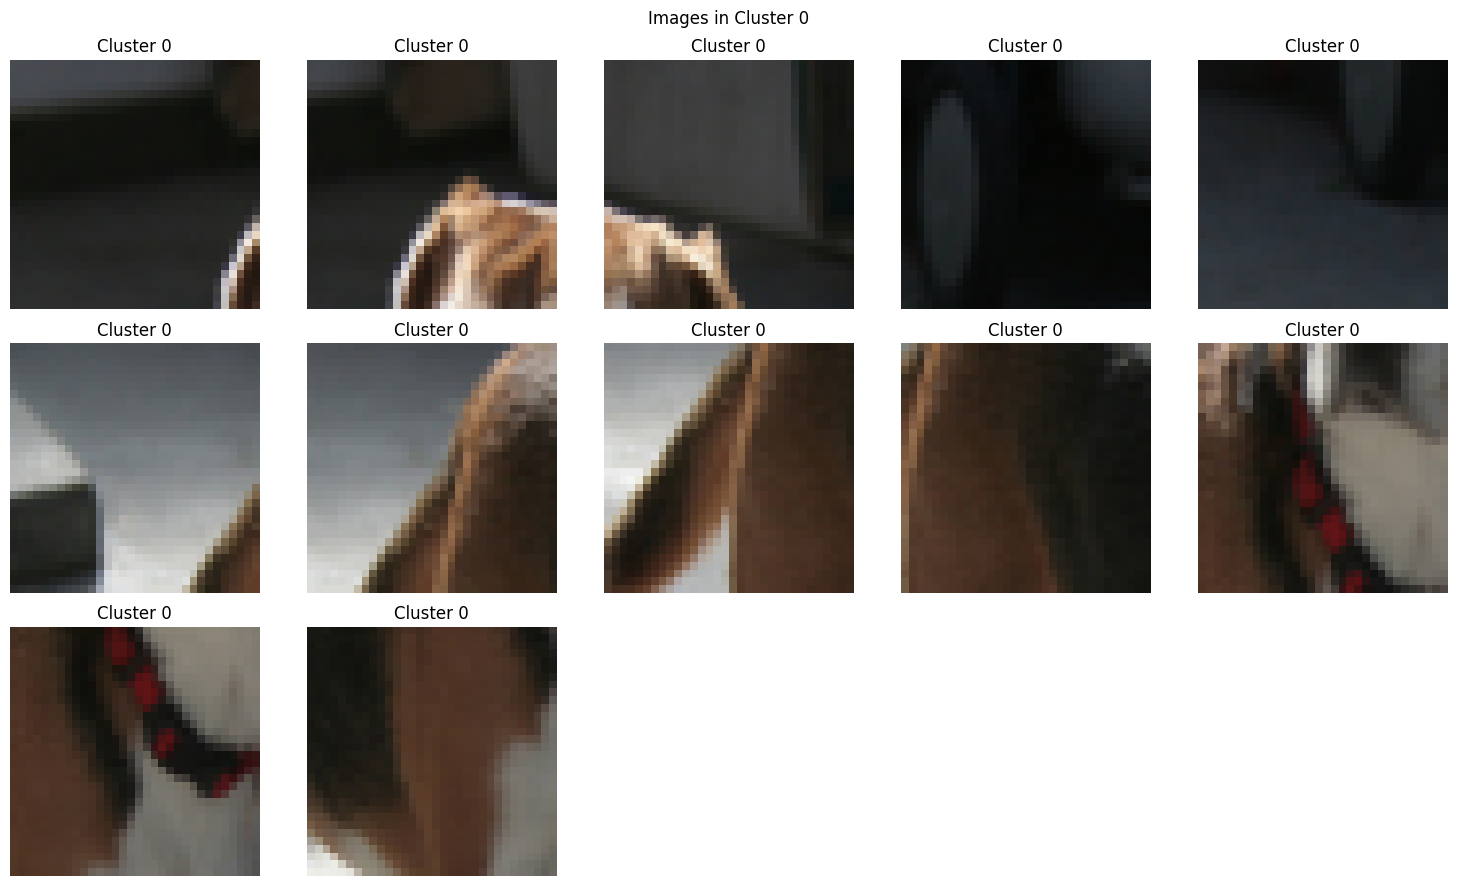

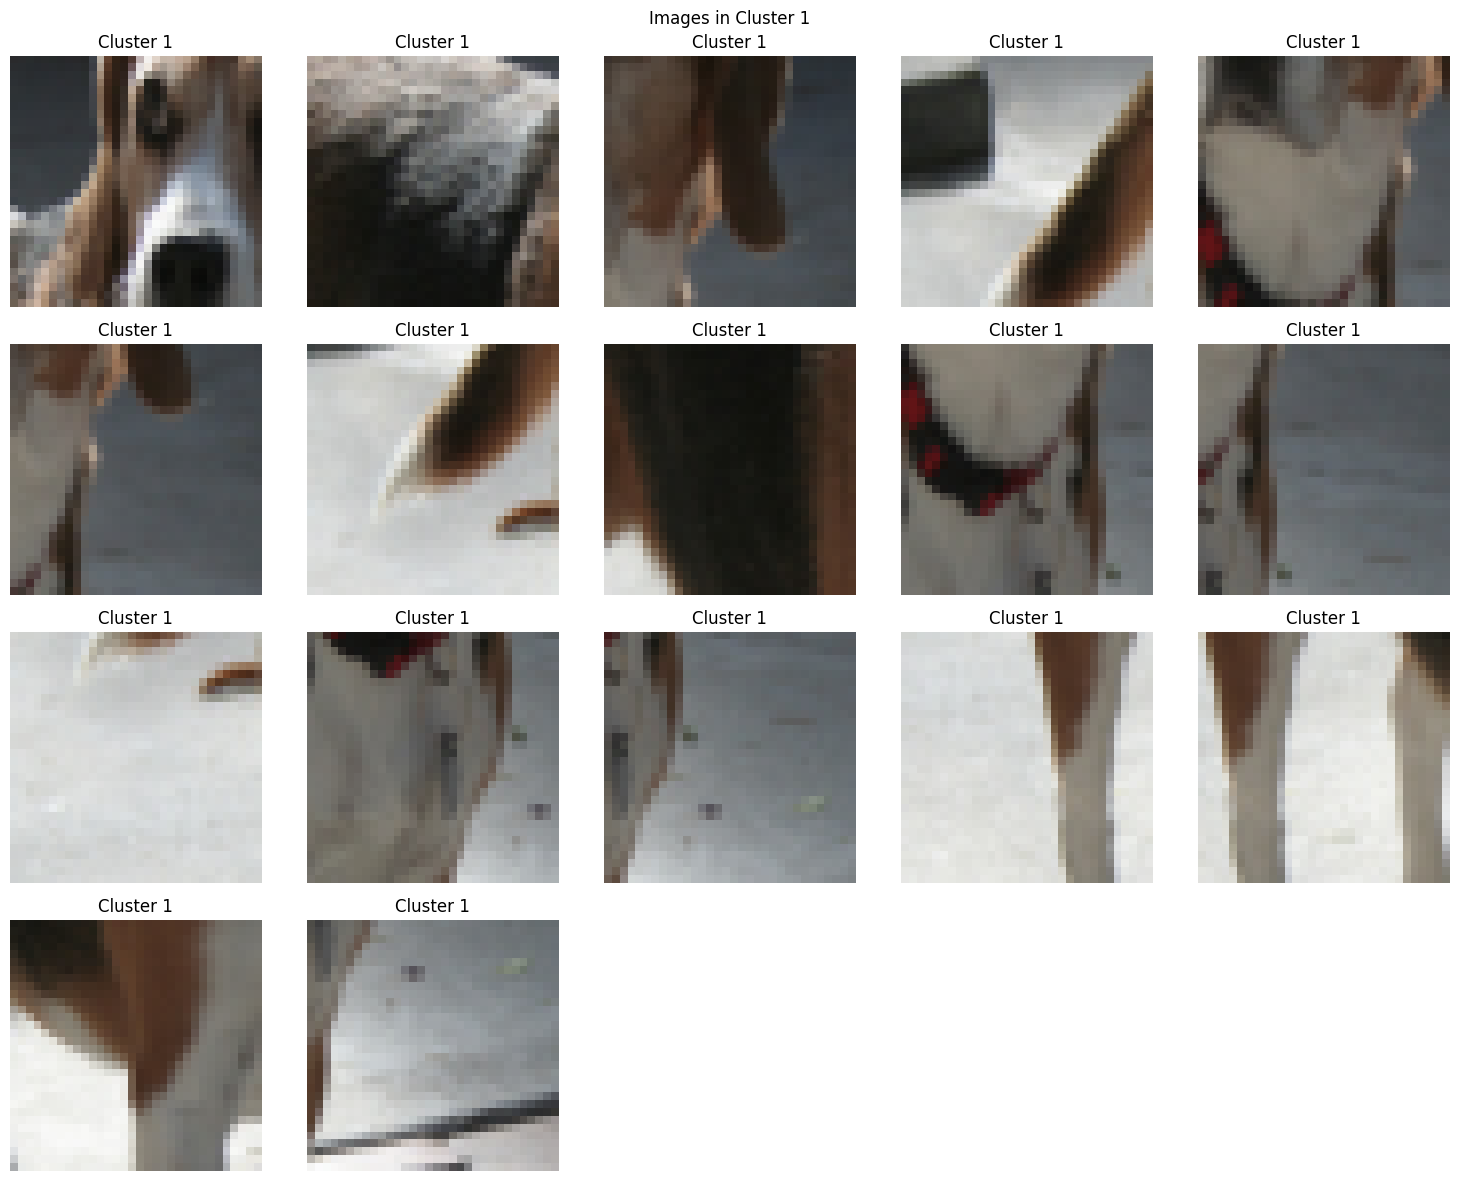

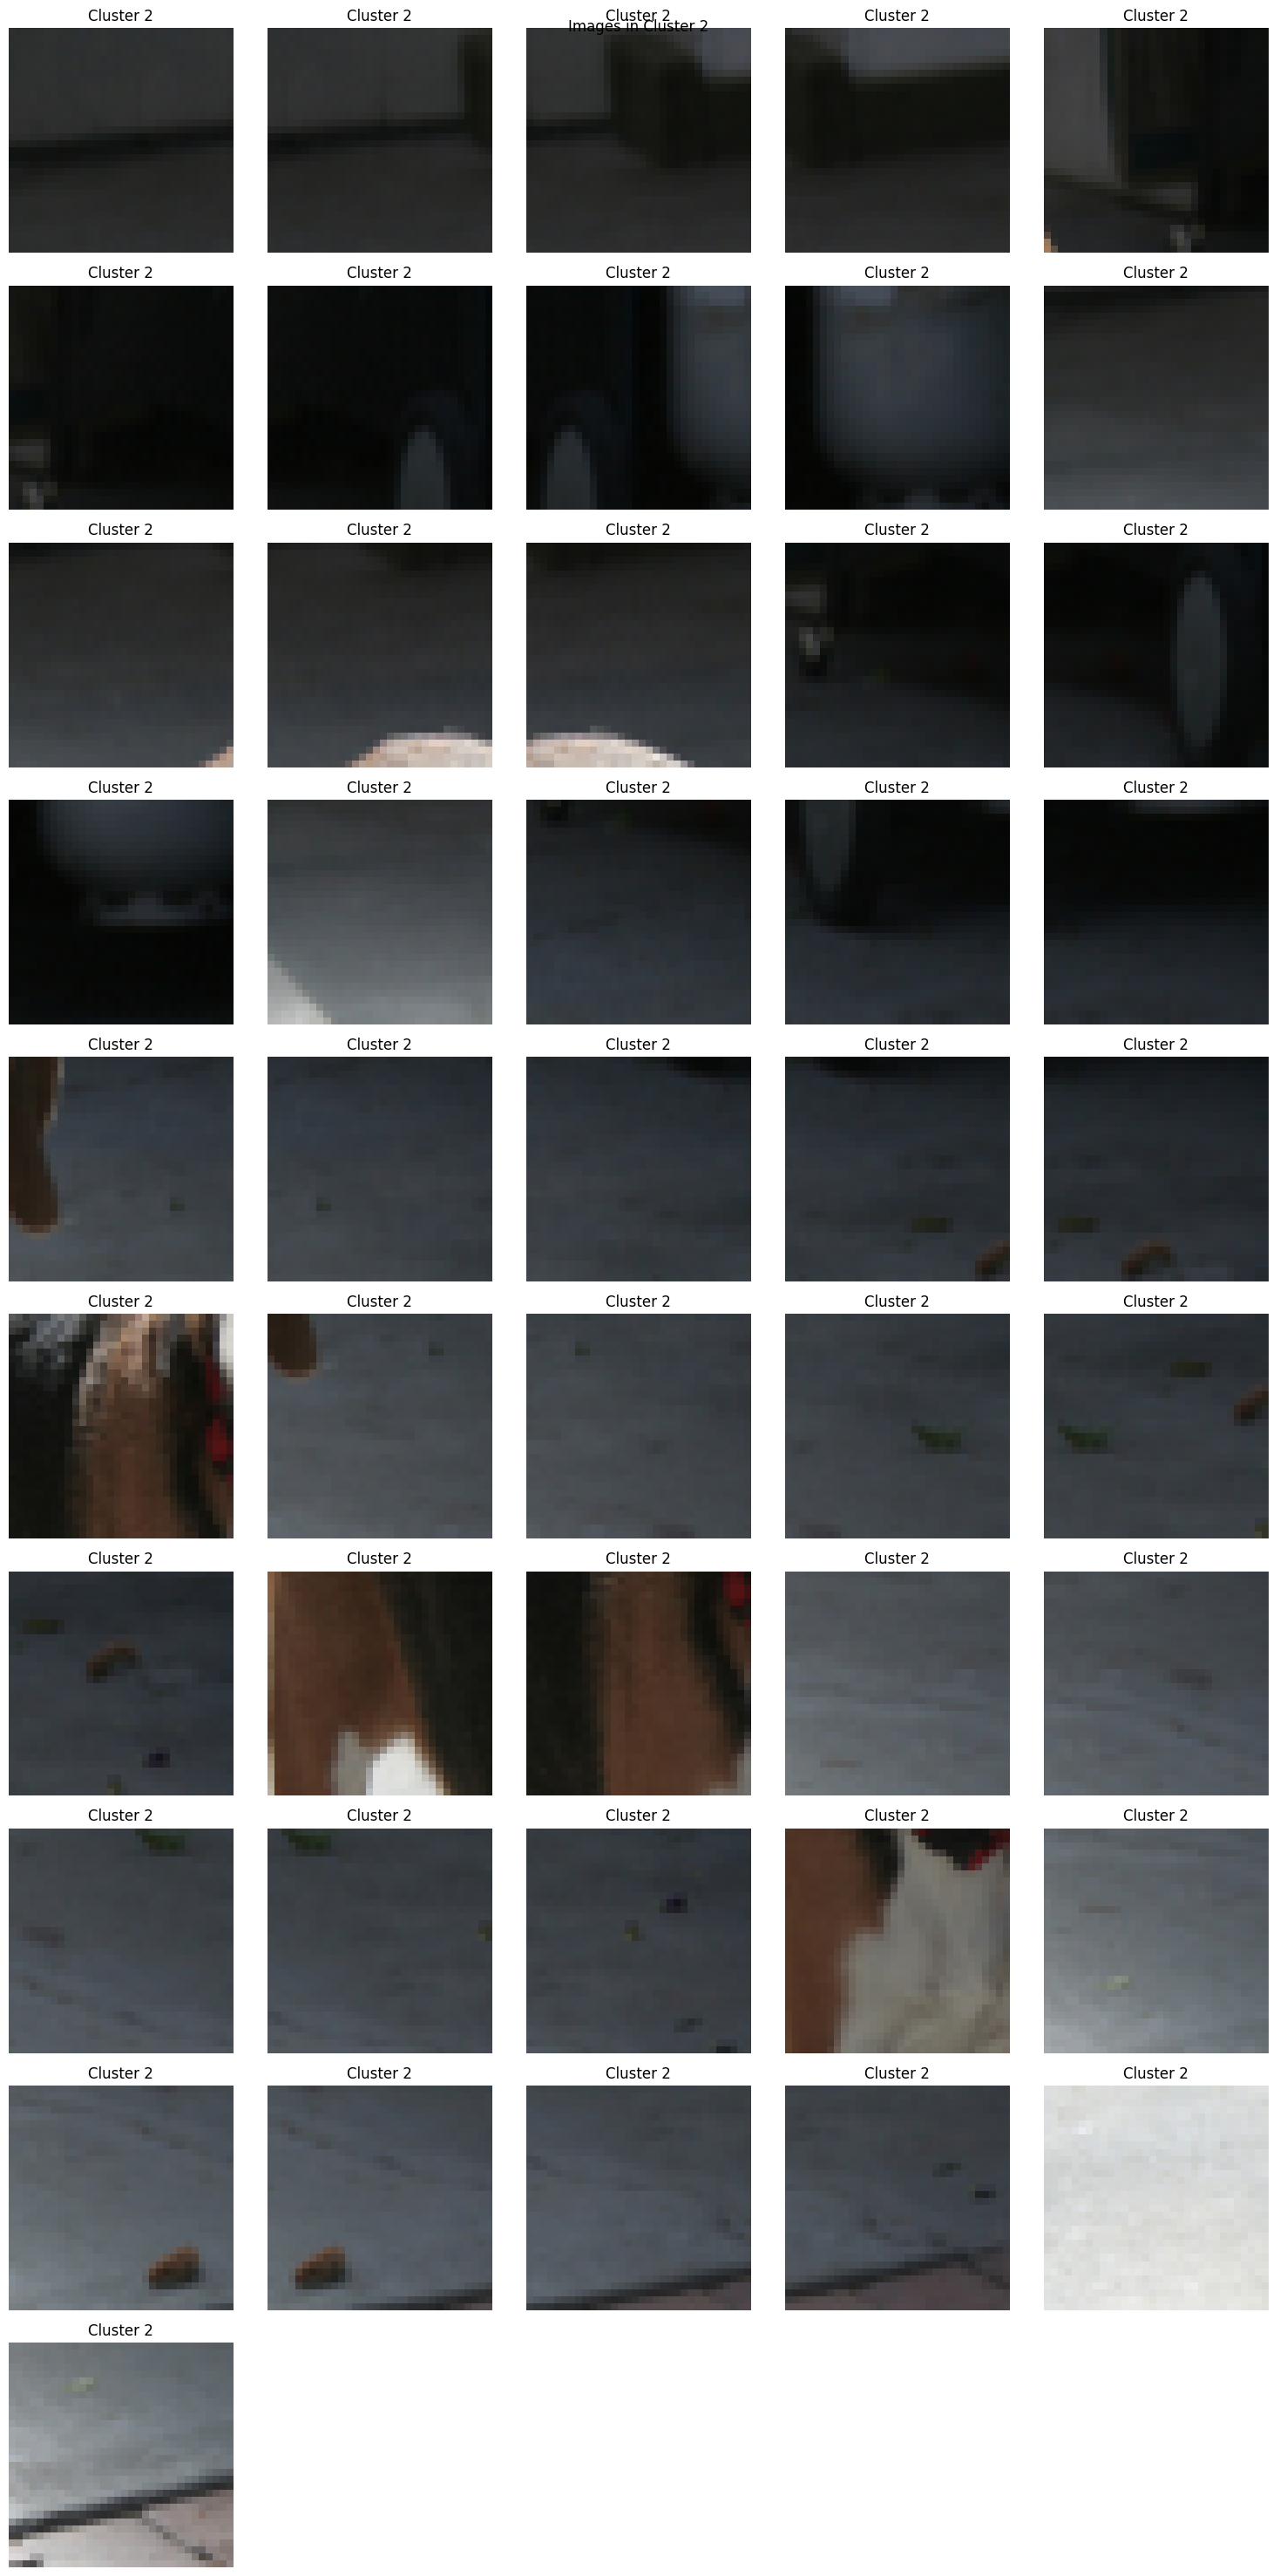

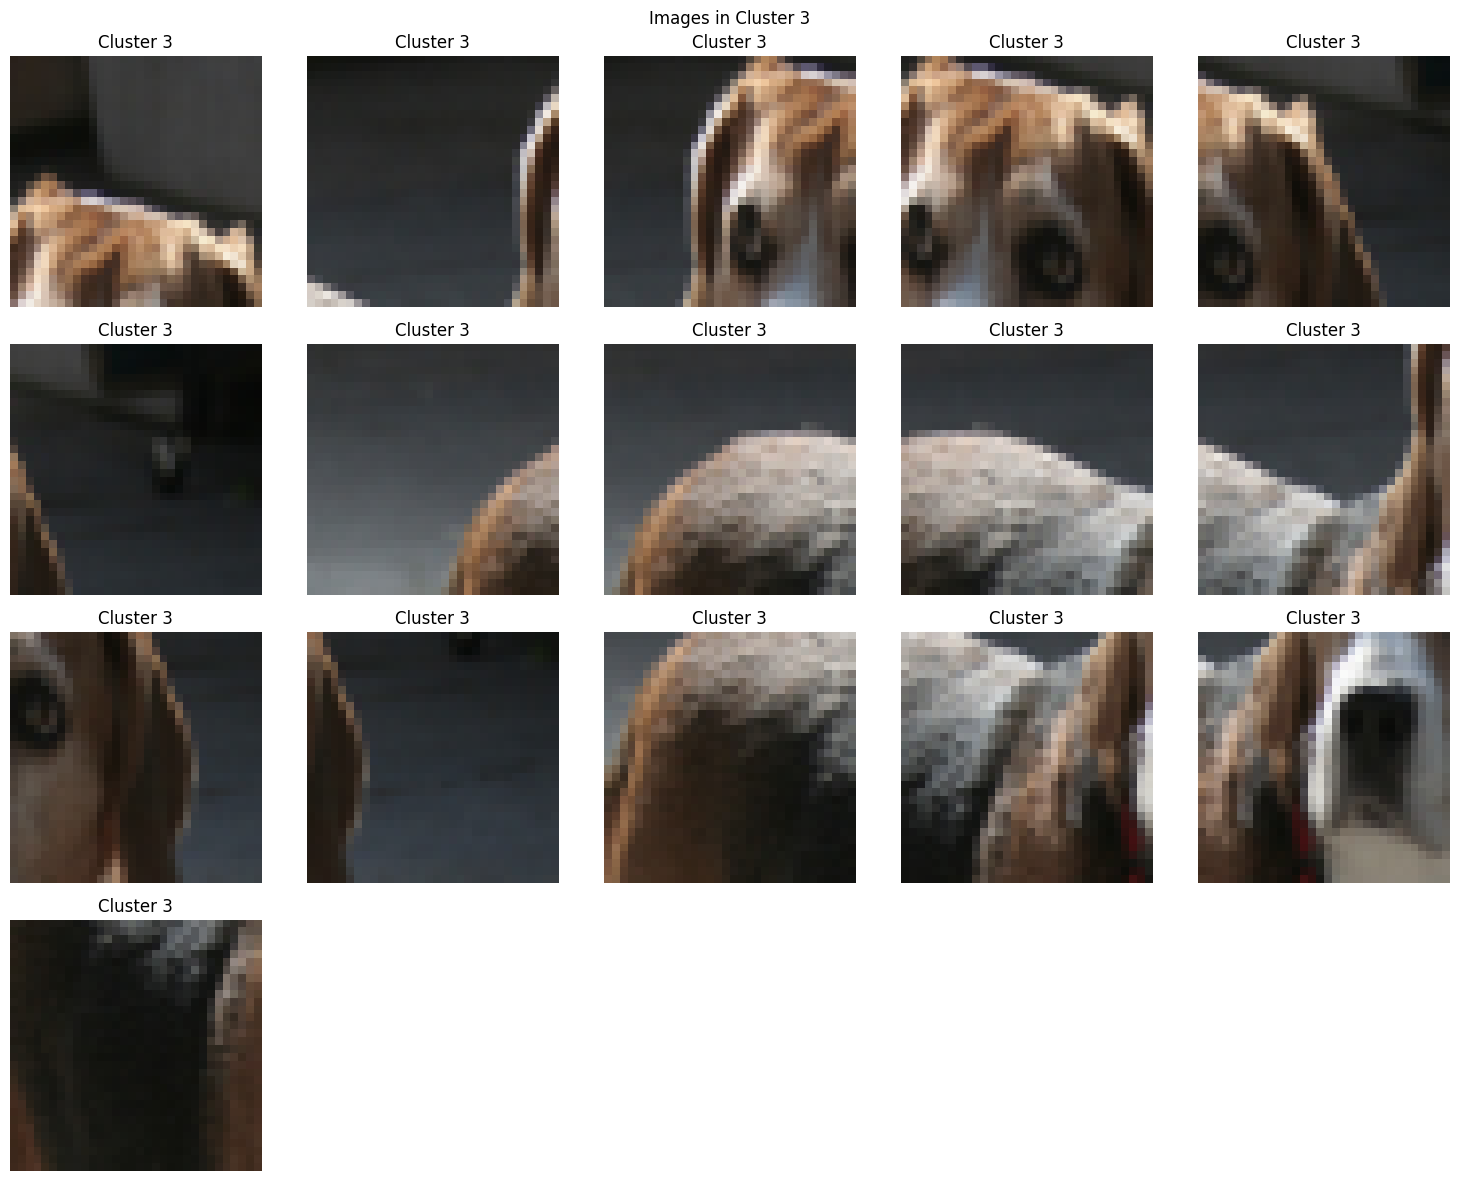

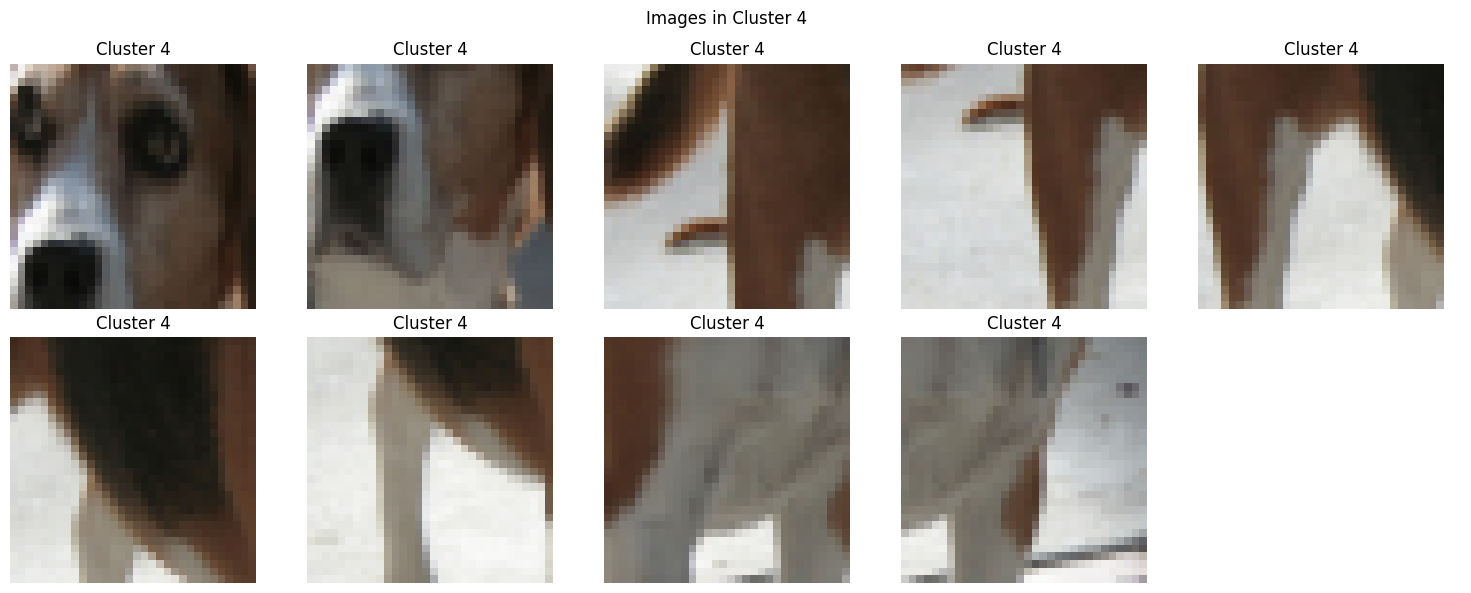

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set the number of clusters
num_clusters = 5  # You can adjust this based on your preference or use a method like elbow method

# Collect reduced embeddings for clustering
reduced_embeddings = [patch_dict[idx]["reduced_embedding"] for idx in patch_dict.keys()]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

# Add cluster labels back to the dictionary
for idx, label in zip(patch_dict.keys(), cluster_labels):
    patch_dict[idx]["cluster"] = label

# Step 3: Display images by cluster
for cluster in range(num_clusters):
    cluster_indices = [idx for idx, data in patch_dict.items() if data["cluster"] == cluster]
    num_patches = len(cluster_indices)
    cols = 5  # Set number of columns for display
    rows = (num_patches // cols) + 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    for i, idx in enumerate(cluster_indices):
        axes[i].imshow(patch_dict[idx]["original"])
        axes[i].axis("off")
        axes[i].set_title(f"Cluster {cluster}")
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"Images in Cluster {cluster}")
    plt.tight_layout()
    plt.show()


Okay based on this it does seem that it clusters in an okay manner, i.e. it seems all the background were put into their own cluster. However, it could be optimized. 


Cosine similarty instead of euclidean distance 

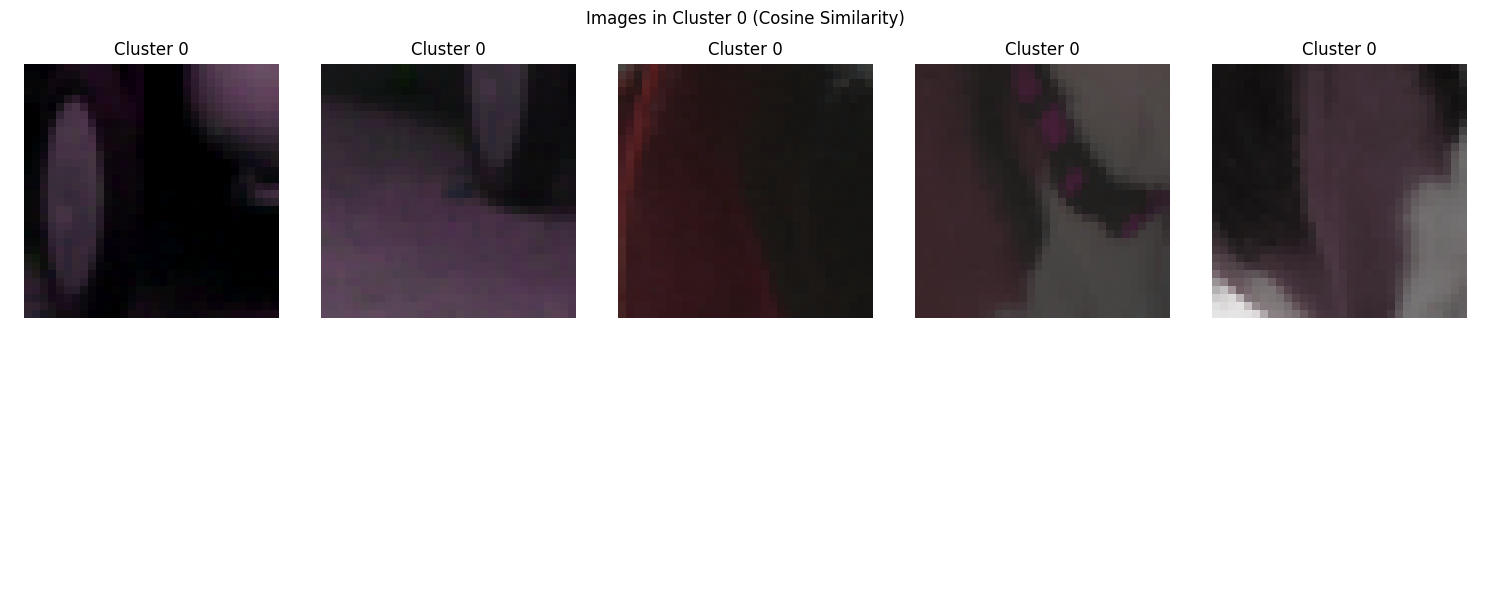

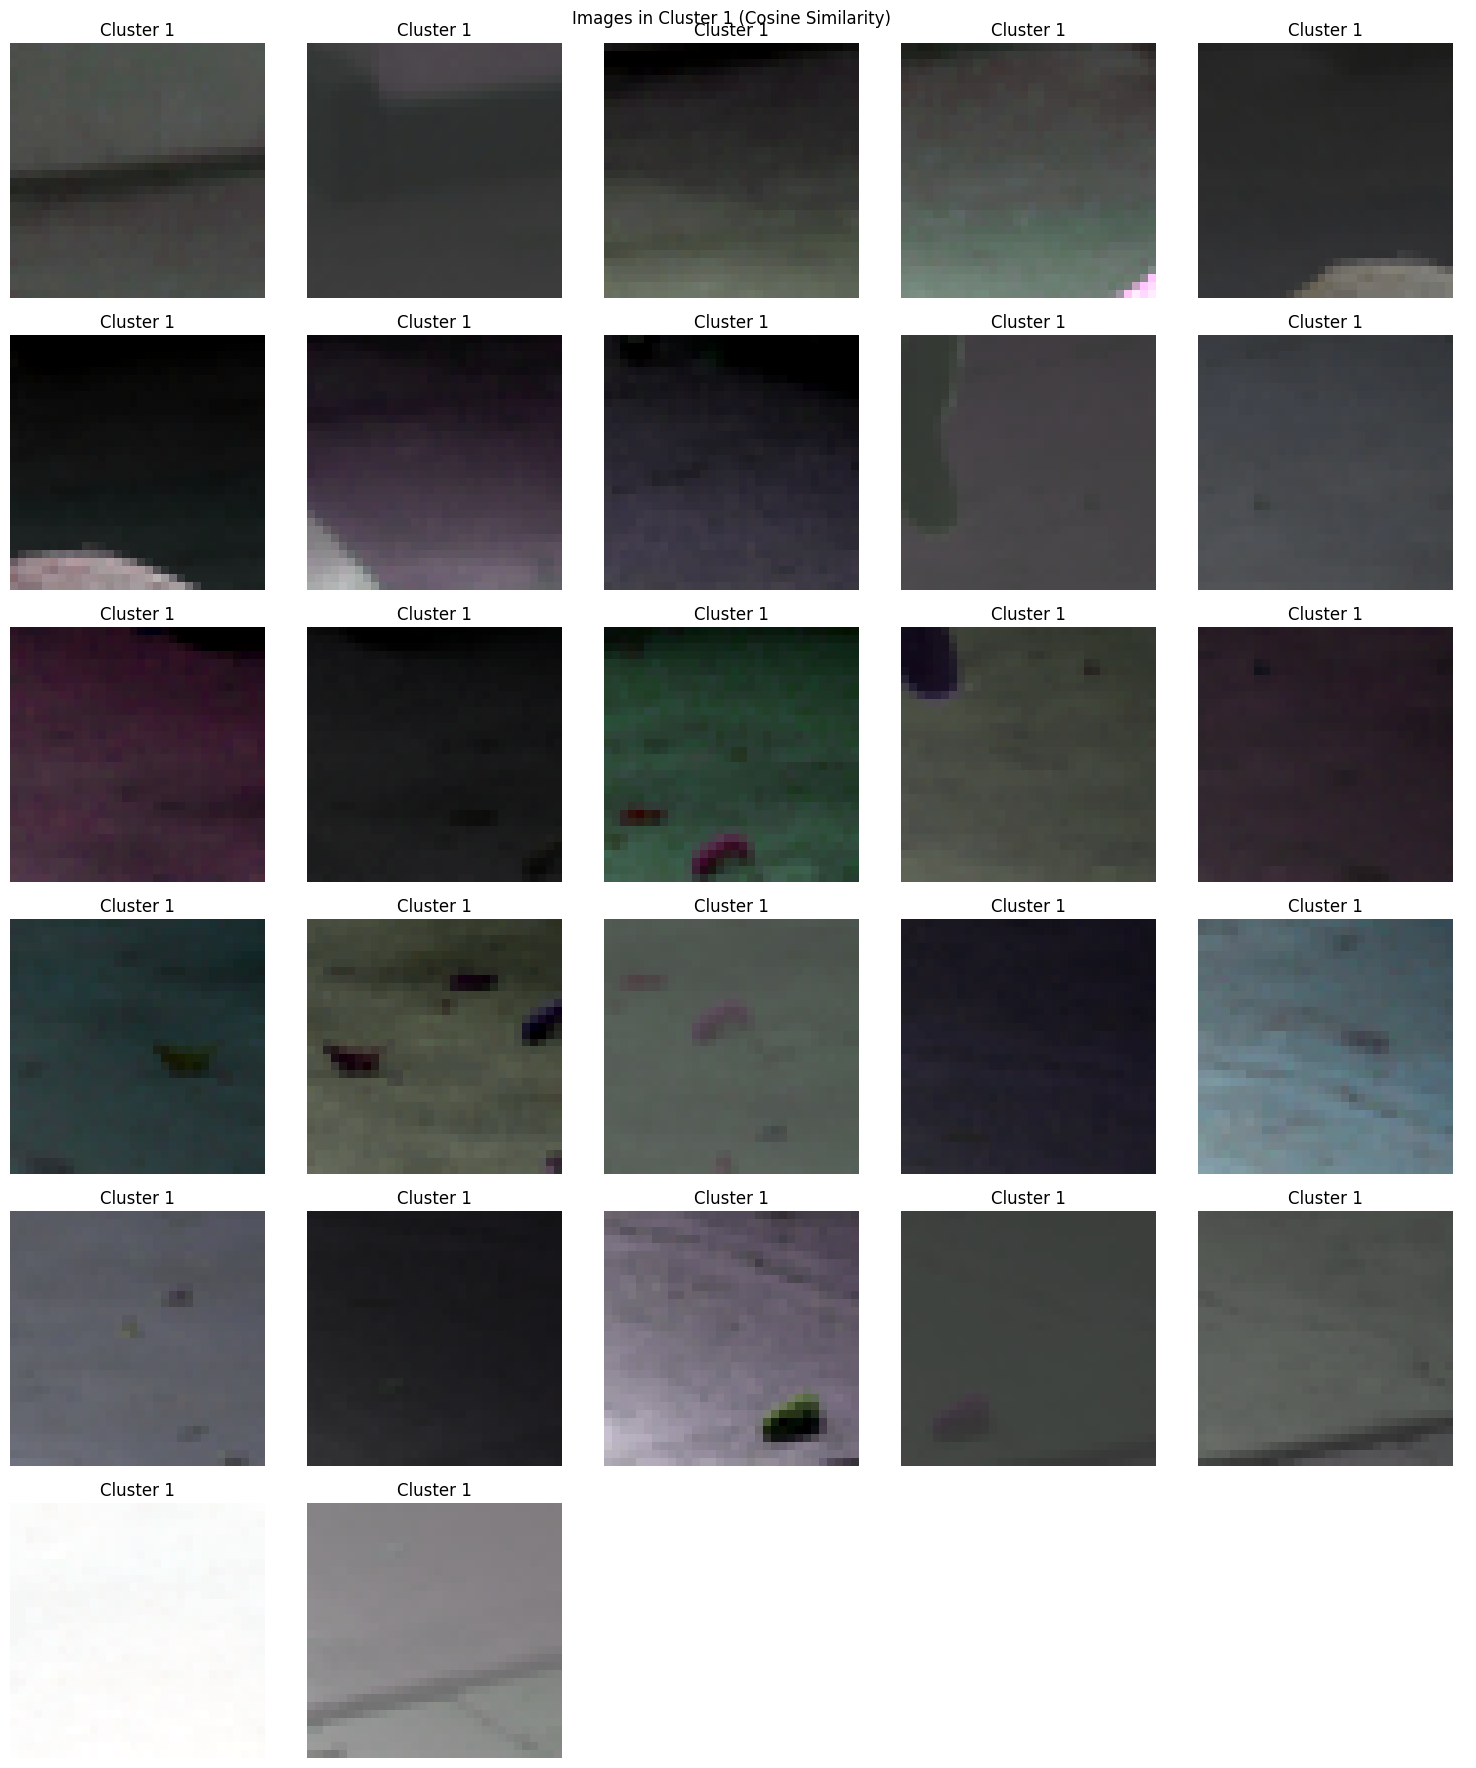

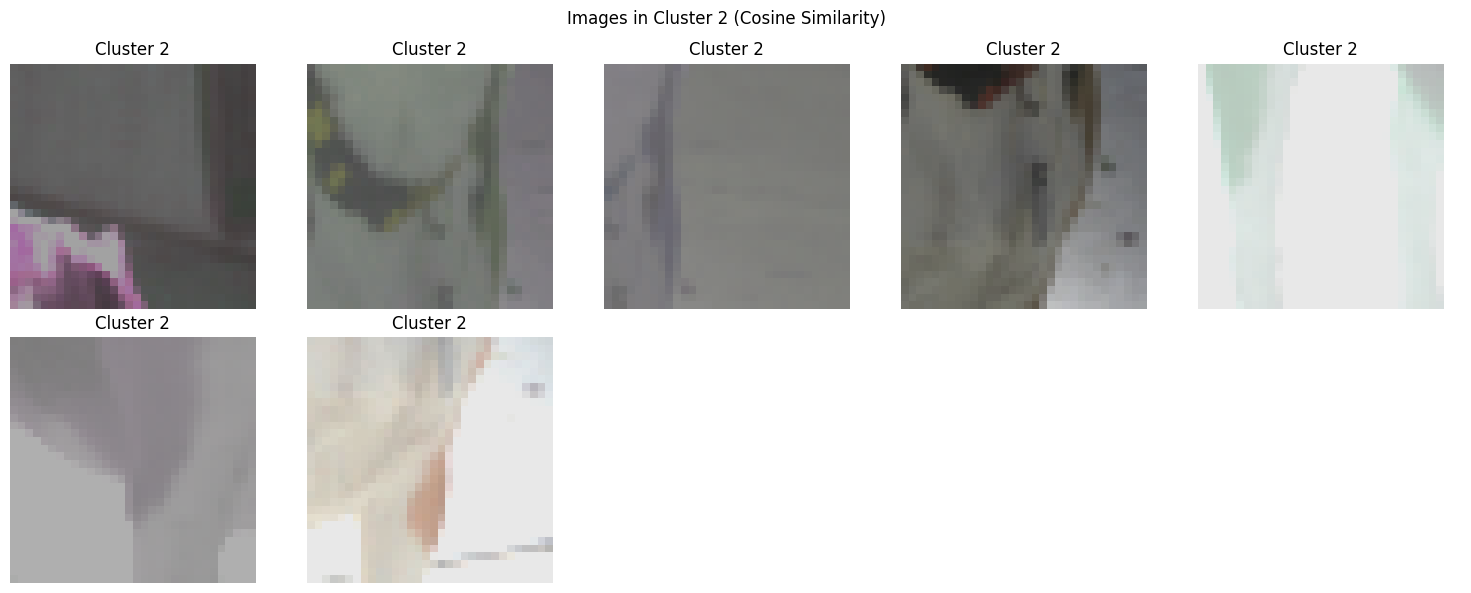

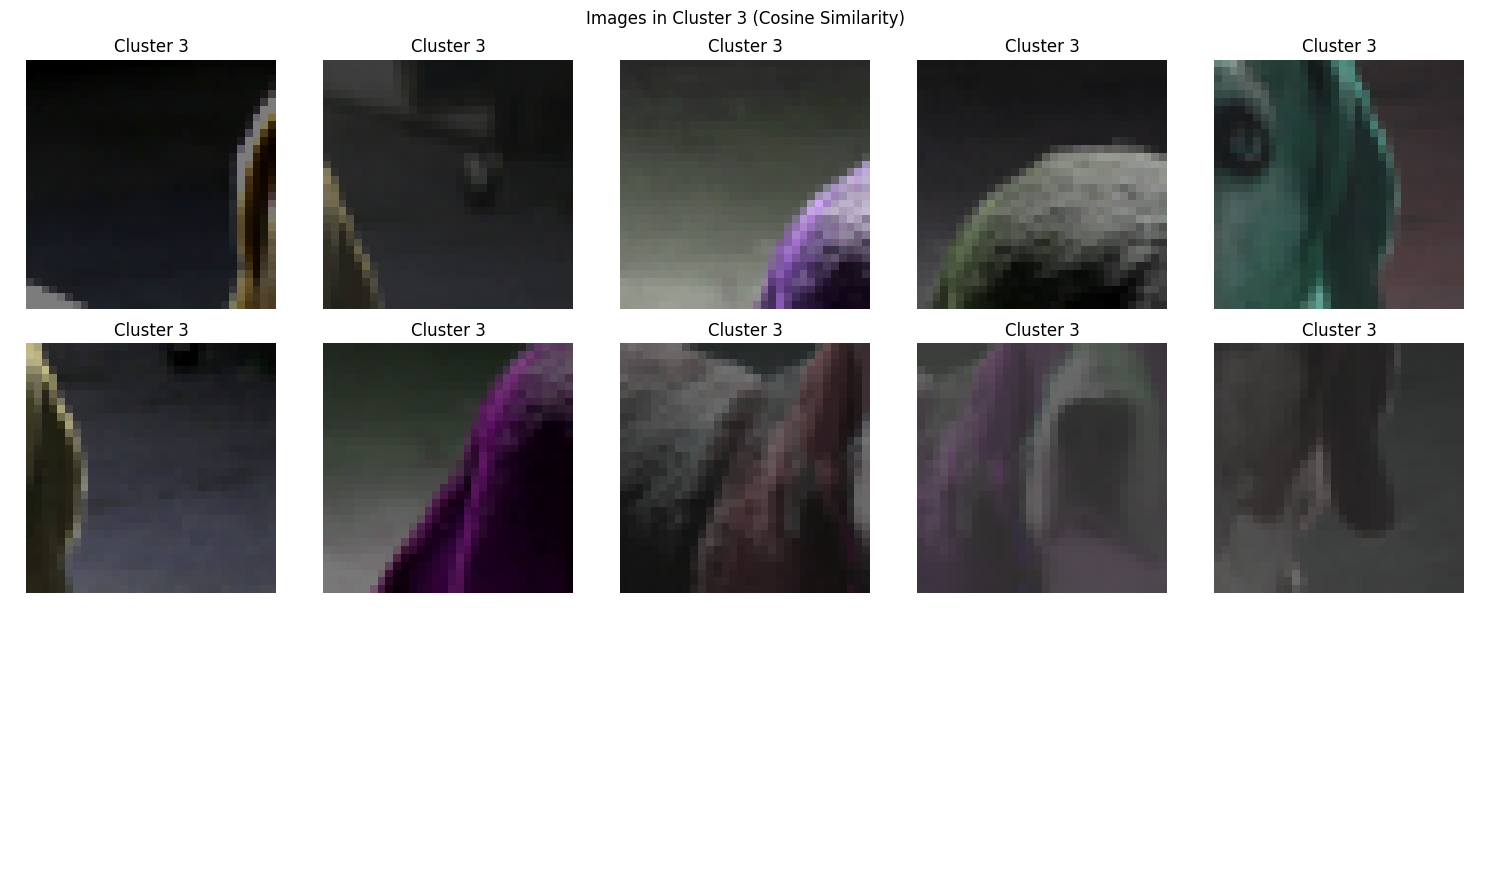

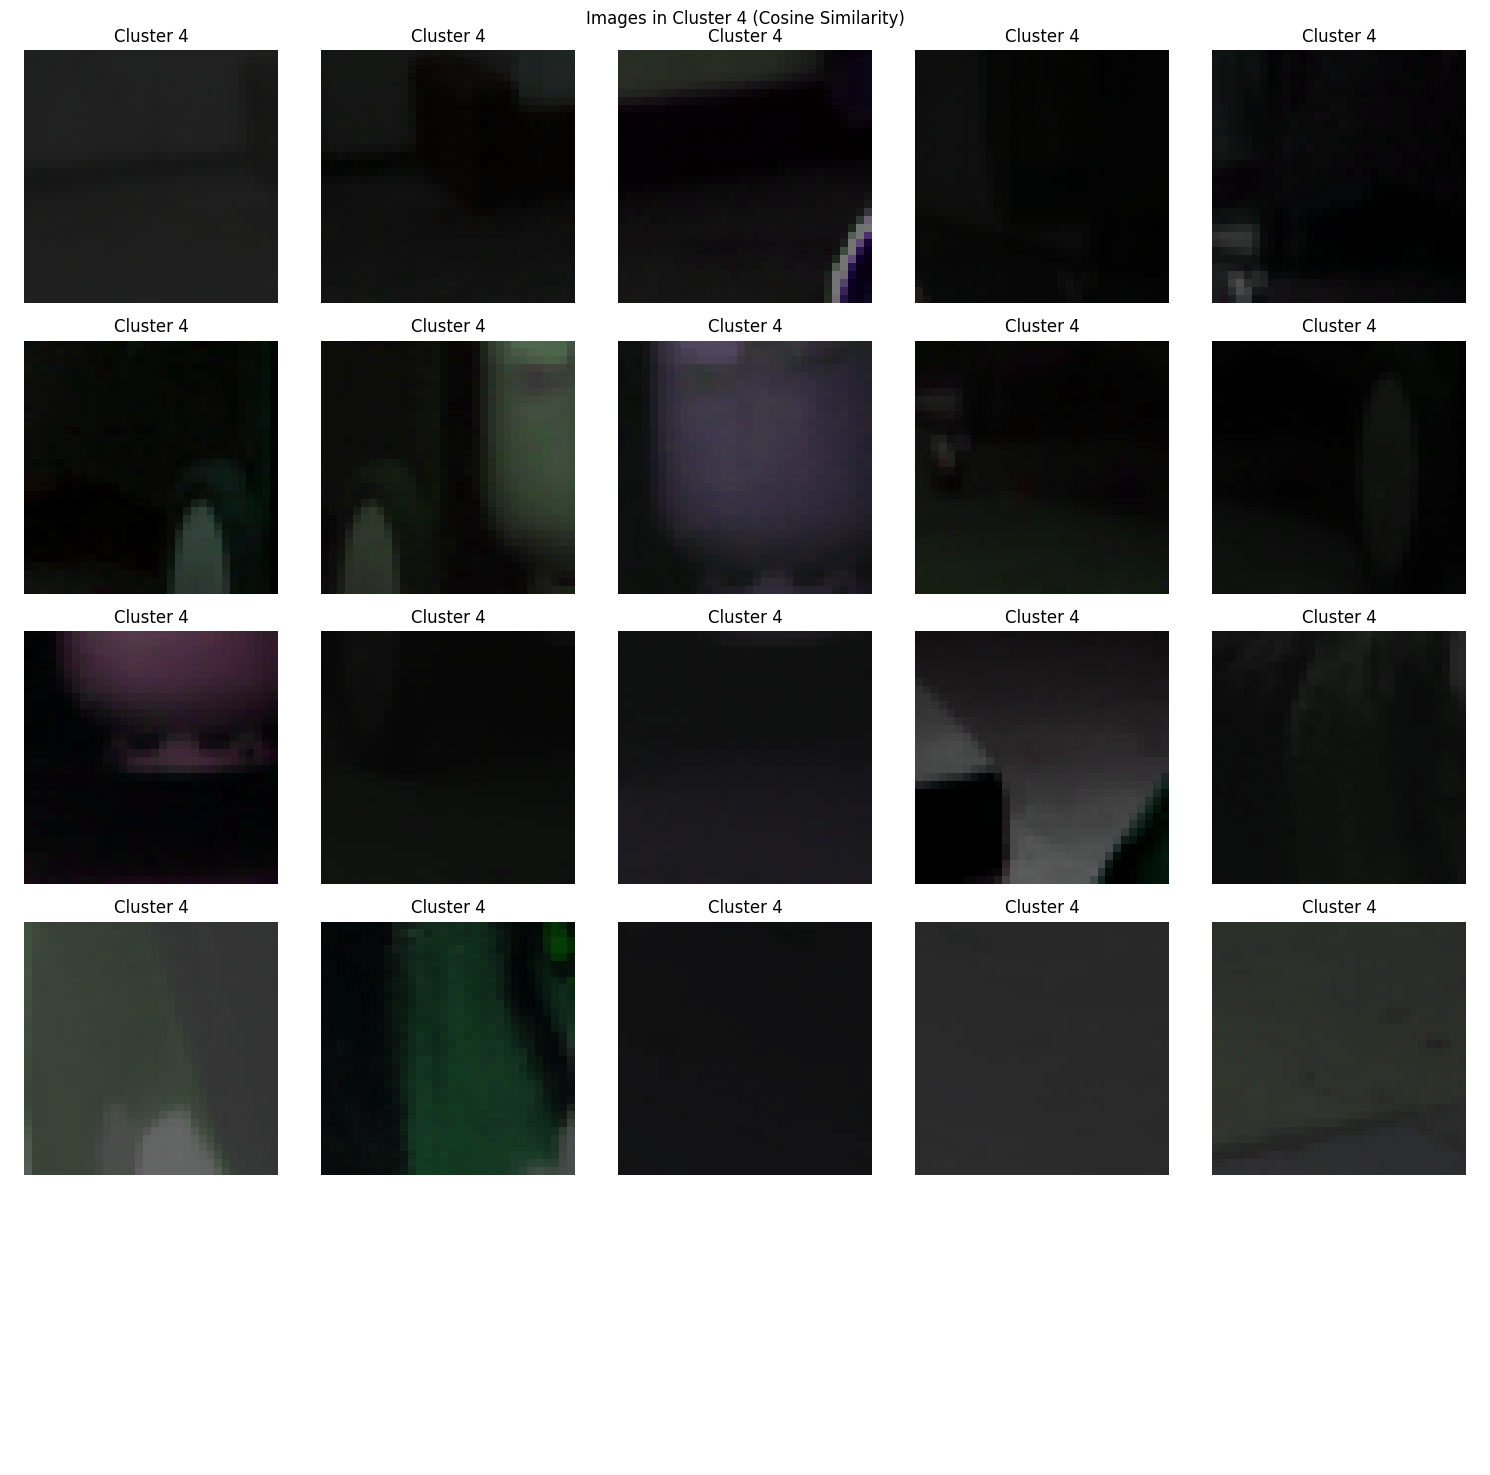

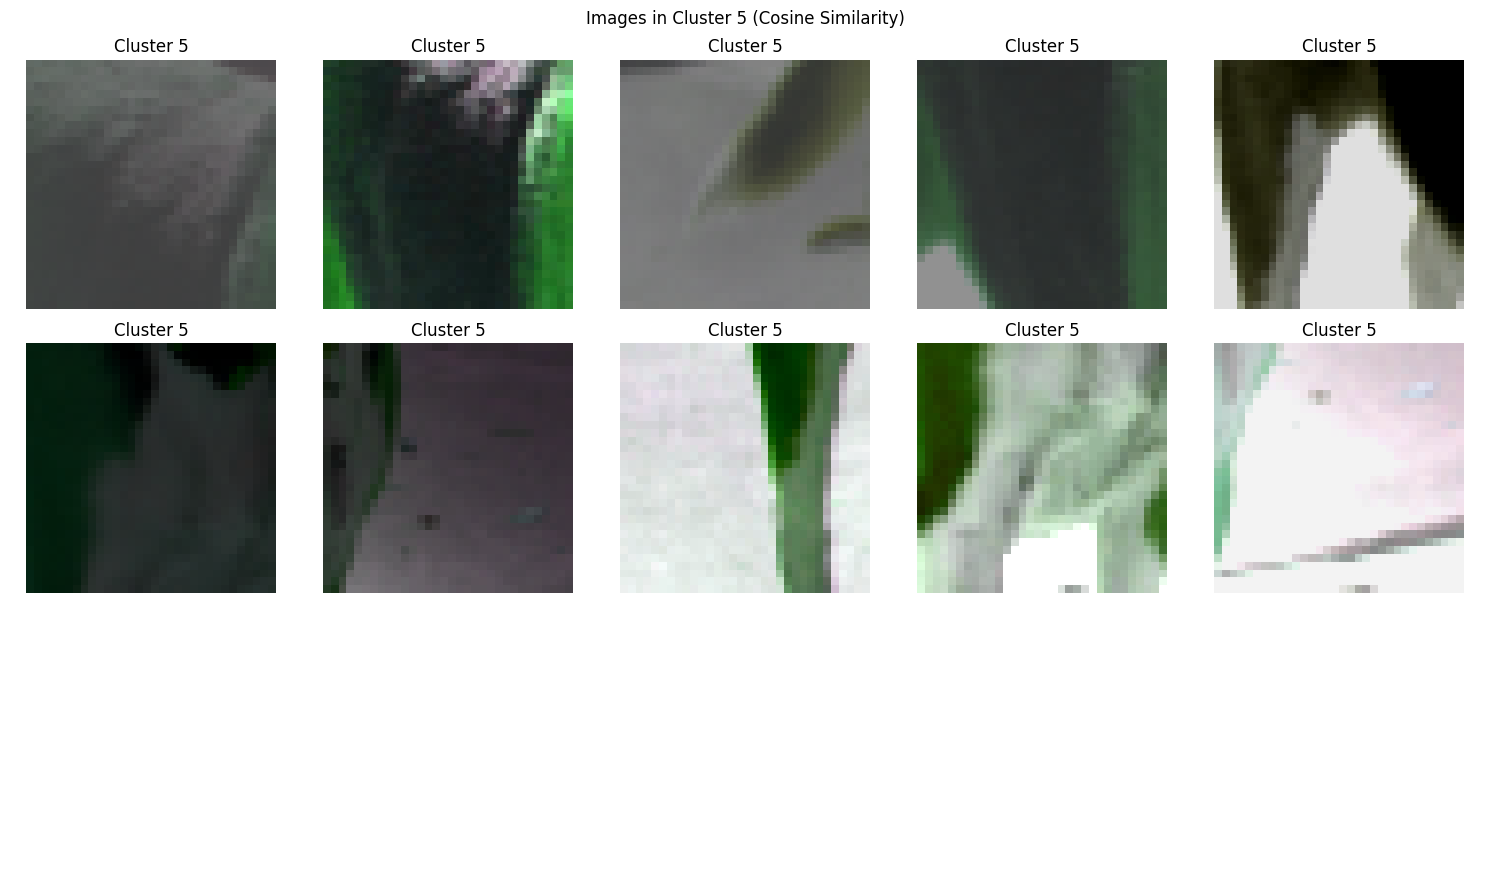

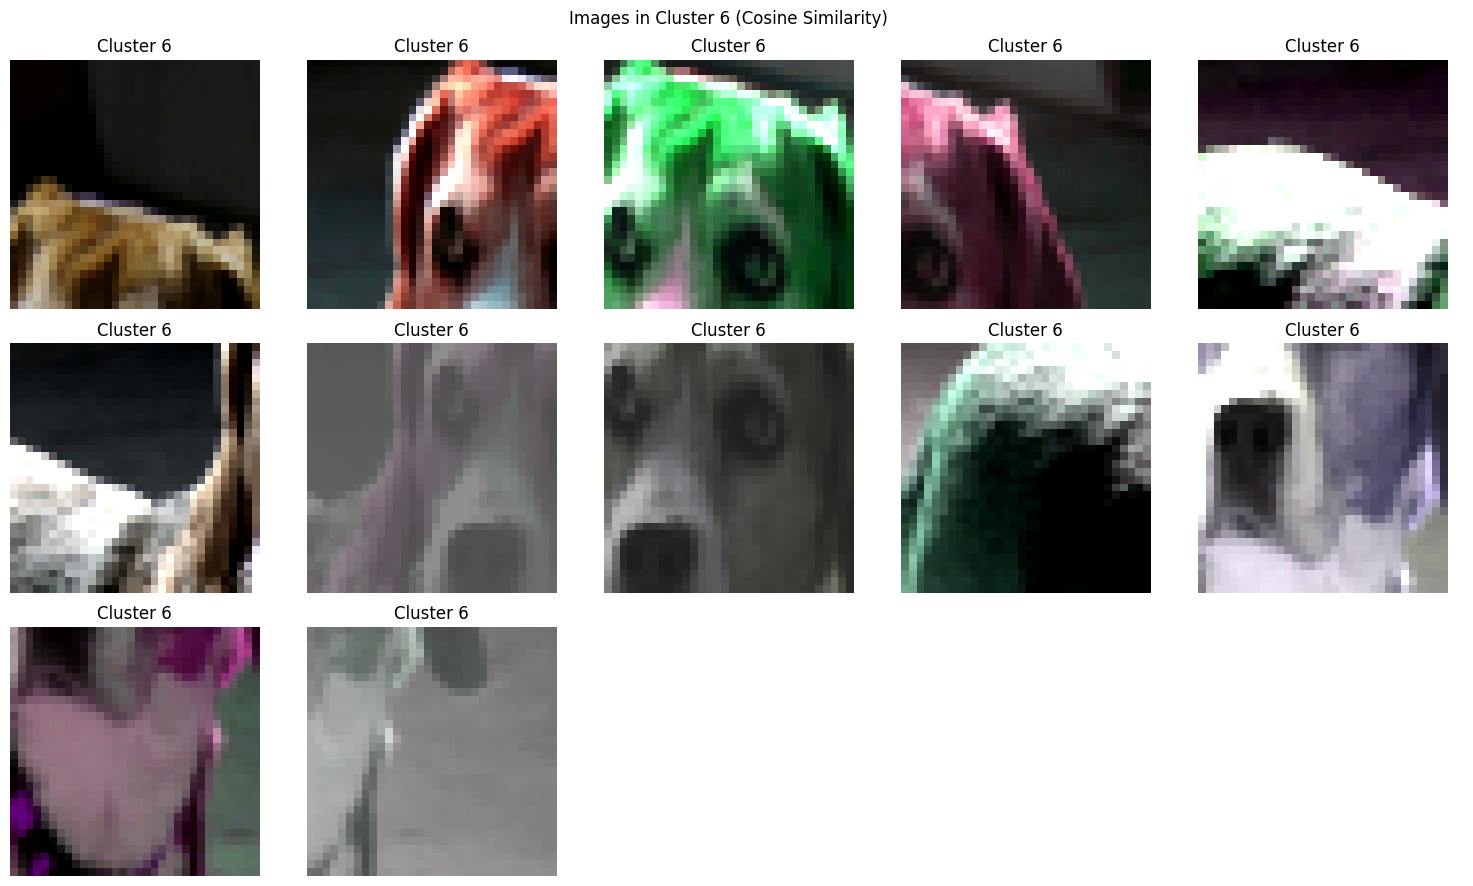

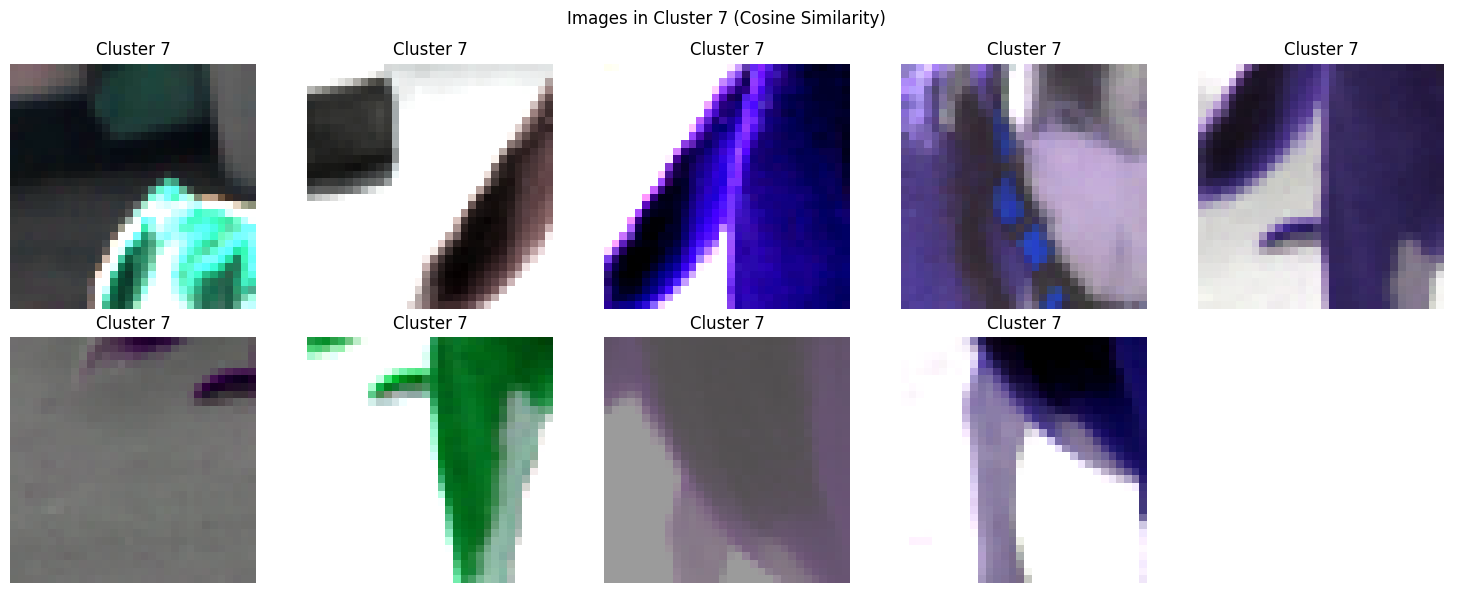

In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# Step 1: Normalize the embeddings to unit length for cosine similarity
normalized_embeddings = normalize([patch_dict[idx]["reduced_embedding"] for idx in patch_dict.keys()])

# Step 2: Apply KMeans clustering on the normalized embeddings
num_clusters = 8  # Set the desired number of clusters
kmeans_cosine = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans_cosine.fit_predict(normalized_embeddings)

# Step 3: Store cluster labels in the dictionary
for idx, label in zip(patch_dict.keys(), cluster_labels):
    patch_dict[idx]["cluster_cosine"] = label

# Step 4: Display images grouped by cluster
for cluster in range(num_clusters):
    cluster_indices = [idx for idx, data in patch_dict.items() if data["cluster_cosine"] == cluster]
    num_patches = len(cluster_indices)
    cols = 5  # Set the number of columns in the grid display
    rows = (num_patches // cols) + 1  # Calculate rows required for the grid

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()  # Flatten for easier indexing

    for i, idx in enumerate(cluster_indices):
        axes[i].imshow(patch_dict[idx]["augmented"])
        axes[i].axis("off")
        axes[i].set_title(f"Cluster {cluster}")

    # Turn off any extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"Images in Cluster {cluster} (Cosine Similarity)")
    plt.tight_layout()
    plt.show()


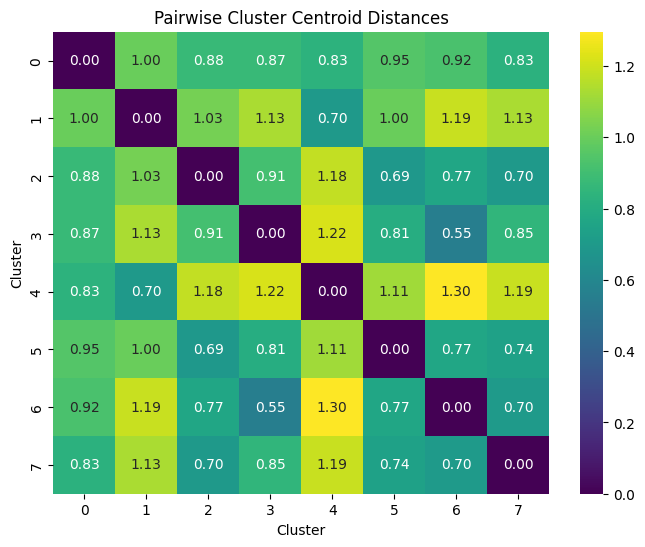

In [38]:
import numpy as np
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Access the cluster centroids
centroids = kmeans_cosine.cluster_centers_  # For KMeans using cosine-similarity

# Step 2: Compute the pairwise distances between centroids
# You can use Euclidean distances here or replace with 'cosine' for cosine distance
centroid_distances = cdist(centroids, centroids, metric='euclidean')

# Step 3: Display the distances in a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(centroid_distances, annot=True, cmap='viridis', fmt=".2f")
plt.title("Pairwise Cluster Centroid Distances")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()
